In [194]:
import pandas as pd
import plotly.express as px
import numpy as np
from datetime import date, datetime
import re

In [195]:
months_names = {
    "январь": 1,
    "февраль": 2,
    "март": 3,
    "апрель":  4,
    "май": 5,
    "июнь": 6,
    "июль": 7,
    "август": 8,
    "сентябрь": 9,
    "октябрь": 10,
    "ноябрь": 11,
    "декабрь": 12
}


file = pd.ExcelFile('./uploads/ipc_mes_02-2024.xlsx', engine = 'openpyxl')

In [196]:
def read_sheet(sheet: str):
    '''
    Скрипт по вытягиваю данных из страницы Excel файла, возвращает DF: значение ИПЦ, дата, тип ИПЦ
    '''
    # убираем верхние колонки, чтобы добраться до данных
    df = sheet.drop(index=[0, 1, 3])
    df.reset_index(inplace = True, drop = True)
    # переназначаем колнки - потребуется, чтобы превратить таблицу в длинный формат
    df.columns = ["Месяц"] + list(map(lambda x: int(x), df.iloc[0,1:].to_list()))
    df.drop(index = [0], inplace = True)
    df.reset_index(inplace = True, drop = True)
    # уменьшаем размер матрица до необходимых данных
    df = df.iloc[0:12, :]
    # делаем в длинный формат
    df = df.melt(id_vars = ["Месяц"], value_vars = df.columns.to_list().remove("Месяц"))
    df.dropna(axis = 0, inplace = True)
    # формируем дату и сразу делаем индексом
    df["date"] = pd.to_datetime(dict(year = df["variable"], month = df["Месяц"].map(months_names), day = 1))
    df.drop(columns=["Месяц", "variable"], inplace = True)
    # на всякий еще назовем тип ИПЦ
    df["ipc_type"] = sheet.columns[0]
    # Уберем данные инфляции 90-х
    df = df[df["date"] >= datetime(2000, 1, 1)]
    df["base"] = df["value"].apply(lambda x: x / 100).cumprod()

    return df

In [197]:
data = pd.DataFrame()
for name in file.sheet_names[1:]:
    sheet = pd.read_excel(file, name)
    data = pd.concat([data, read_sheet(sheet)])


C:\Users\ska19\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



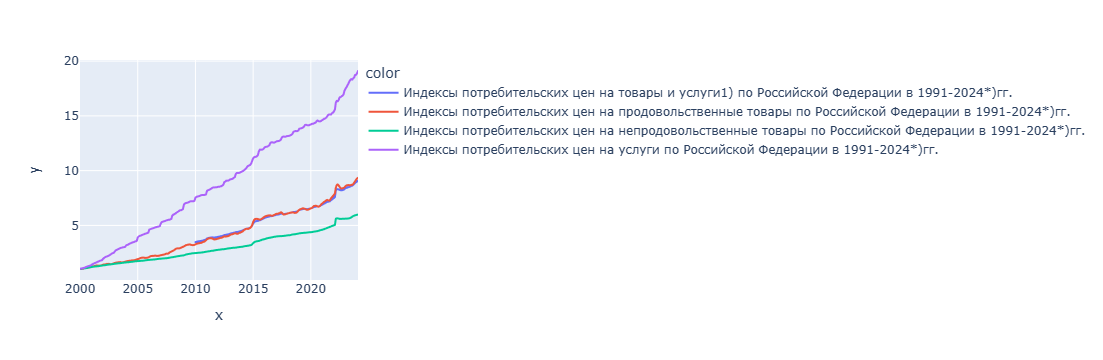

In [203]:
px.line(data_frame = data, x = data["date"][120:], y = data["base"][120:], line_group=data["ipc_type"][120:], color = data["ipc_type"][120:])

In [209]:
list(filter(lambda name: "Содерж" not in name, file.sheet_names))

['01', '02', '03', '04']

In [313]:
class Model:
    '''
    Класс "модель" принимает на вход файл.
    Имеет следующие атрибуты:
    
    Обладает следующими методами:
    
    '''
    def __init__(self, file_name: str, data = pd.DataFrame(), sheets = []):
        self.file_name = file_name
        self.sheets = sheets
        self.data = data
        self.excel_file = None

    def __str__(self):
        self.file_name = str(self.file_name)
        return self.file_name
        
    def __read_excel(self):
        '''
        Считывает файл и выводит его листы, за исключением Содержания
        '''
        self.excel_file = pd.ExcelFile(self.file_name, engine = 'openpyxl')
        if not self.sheets:
            self.sheets = list(filter(lambda name: "Содерж" not in name, self.excel_file.sheet_names))
        else:
            self.sheets = list(filter(lambda name: "Содерж" not in name, self.sheets))
        pass
    
    def __extract_sheet(self, sheet):
        '''
        Метод по вытягиванию данных из страницы Excel файла, возвращает DF: значение ИПЦ MoM, дата, тип ИПЦ, base
        Для модели убираем данные до 01-01-2000
        '''
        sheet = pd.read_excel(self.excel_file, sheet)
        # убираем верхние колонки, чтобы добраться до данных
        df = sheet.drop(index=[0, 1, 3])
        df.reset_index(inplace = True, drop = True)
        # переназначаем колнки - потребуется, чтобы превратить таблицу в длинный формат
        df.columns = ["Месяц"] + list(map(lambda x: int(x), df.iloc[0,1:].to_list()))
        df.drop(index = [0], inplace = True)
        df.reset_index(inplace = True, drop = True)
        # уменьшаем размер матрица до необходимых данных
        df = df.iloc[0:12, :]
        # делаем в длинный формат
        df = df.melt(id_vars = ["Месяц"], value_vars = df.columns.to_list().remove("Месяц"))
        df.dropna(axis = 0, inplace = True)
        # формируем дату и сразу делаем индексом
        df["date"] = pd.to_datetime(dict(year = df["variable"], month = df["Месяц"].map(months_names), day = 1))
        df.drop(columns=["Месяц", "variable"], inplace = True)
        # на всякий еще назовем тип ИПЦ
        df["ipc_type"] = sheet.columns[0]
        # Уберем данные инфляции 90-х
        df = df[df["date"] >= datetime(2000, 1, 1)]
        df["base"] = df["value"].apply(lambda x: x / 100).cumprod()

        return df
    
    def preprocess_excel(self):
        '''
        Метод подготовки данных из эксель для модели, результат записывается в атрибут data/
        '''
        self.__read_excel()
        
        # проверяем, что df пустой, иначе очищаем данные
        if self.data.empty:
            self.data = pd.DataFrame()
        # пробегаемся по листам с данными и возвращаем итоговый датасет
        for sheet in self.sheets:
            self.data =  pd.concat([self.data, self.__extract_sheet(sheet)])
            
        return self.data

    def create_graphs(self):
        if self.data.empty:
            self.preprocess_excel()
        return px.line(self.data, x = "date", y = "base", title = "График динамики ИПЦ", line_group = "ipc_type", color = "ipc_type")

In [314]:
test = Model(file_name = "./uploads/ipc_mes_02-2024.xlsx")

C:\Users\ska19\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



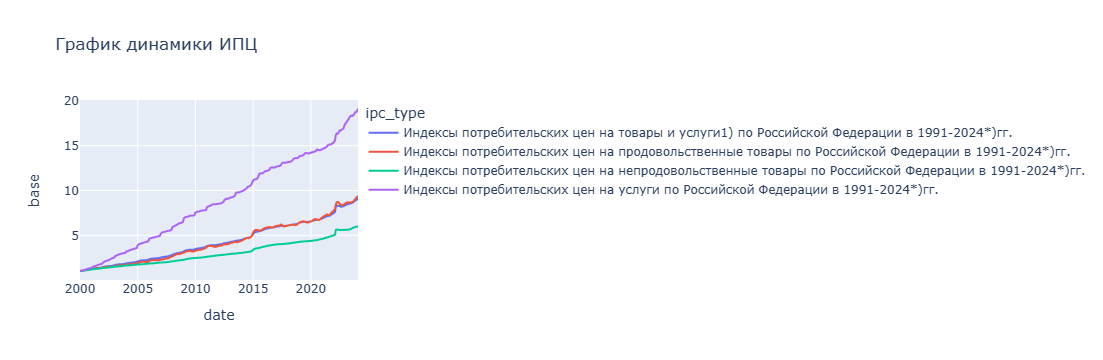

In [315]:
test.create_graphs()

In [289]:
test.read_excel()

In [275]:
print(test.sheets)

[]


In [290]:
test.sheets

['01', '02', '03', '04']

In [291]:
test.excel_file

In [283]:
test.excel_file.sheet_names

['Содержание', '01', '02', '03', '04']

In [284]:
if not test.sheets:
    print("ok")

ok
